In [25]:
from connection import pre_process_sc
from connection import build_one_area
from connection import coordination
from connection import poisson_stimuli

import brian2.numpy_ as np
from brian2.only import *

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm_notebook
from matplotlib.animation import FFMpegWriter
import time
import os
import datetime
import sys
import pickle

lattice = coordination.makelattice(64, 64, [0,0])



{'I_extnl': 0, 'pois_extnl_r_1': 8, 'pois_extnl_r_2': 8, 'delta_gk_1': 6.5, 'new_delta_gk_1': 0, 'tau_k': 60, 'tau_s_di': 4.5, 'tau_s_de': 5, 'tau_s_r': 1, 'num_ee': 270, 'num_ei': 350, 'num_ii': 180, 'num_ie': 130, 'simutime': 10000, 'chg_adapt_range': 6, 'ie_r_e': 3.093103448275862, 'ie_r_e1': 0.740025, 'ie_r_i': 2.745689655172414, 'ie_r_i1': 0.6784, 't_ref': 4, 'seed_num': None}


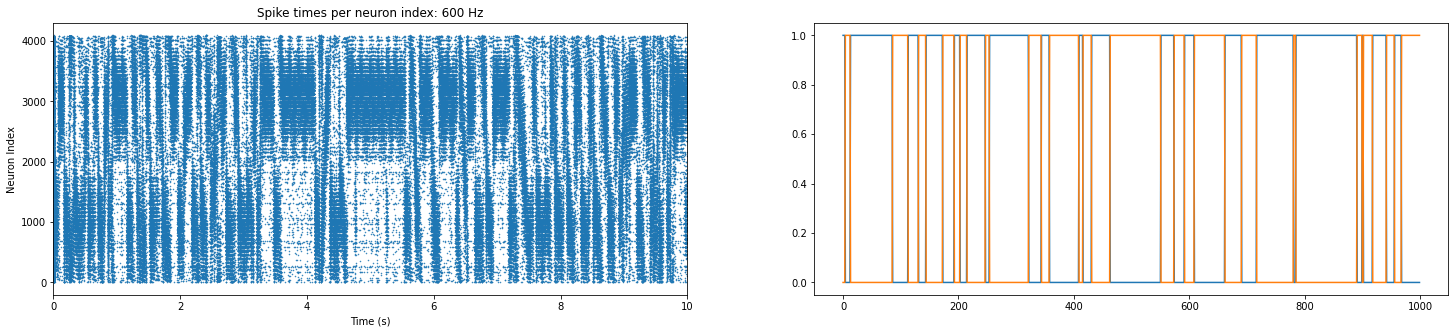

In [42]:
filepath = 'C:/Users/Evan Xie/Documents/GitHub/NeuroNet_brian/raw_data/'
filename = 'adaptation_switching_0.pickle'   # stimulus_contrast_600
# filepath = 'C:/Users/Evan Xie/Documents/GitHub/Complex-systems-EE/SNN/simulations/'
# filename = 'two_stim.pickle'
# C:\Users\Evan Xie\Documents\GitHub\NeuroNet_brian\raw_data

# filename = 'test_sim.pickle'
with open(filepath+filename, 'rb') as handle:
    data = pickle.load(handle)
spike_times = data['a1']['ge']['t']    # ms
spike_index = data['a1']['ge']['i']
payoffs = data['stim']['payoffs']

class params:
    def __init__(self):
        self.options = len(payoffs)
        self.time = len(payoffs[0])
        self.strength = data['stim']['strength']
        self.size = data['stim']['size']
        self.locations = data['stim']['location']
p = params()
# print(p.options,p.time,p.strength,p.size,p.locations)
print(data['param'])

# plt.figure(figsize=(25,5))
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(25,5))
ax1.plot(spike_times/10000,spike_index,'.',markersize=1)
# plt.plot(linspace(0,10,len(payoffs[0,:])),payoffs[1,:]*1000,linewidth=3)
ax1.set_xlim([0,(spike_times[-1]+1)/10000])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Neuron Index')
ax1.set_title('Spike times per neuron index: '+str(p.strength)+' Hz')

ax2.plot(payoffs.T)

plt.show()

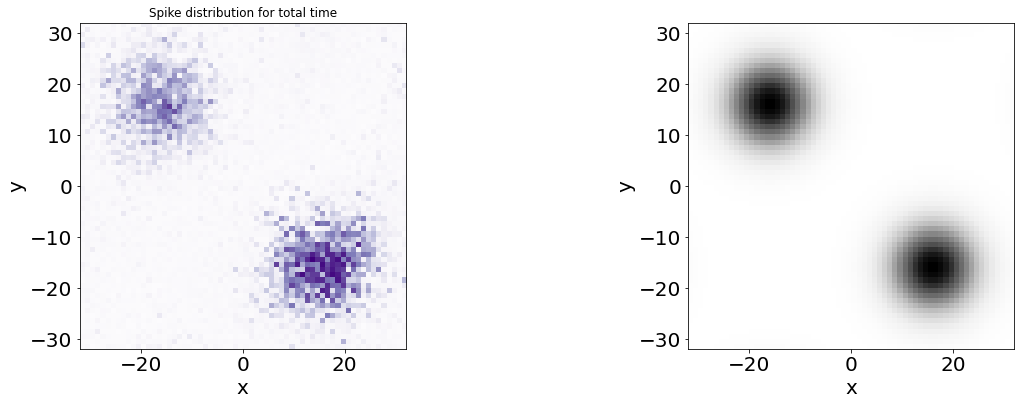

In [43]:
'''Plotting a histogram of spiking locations over the total simulation time.''' 
%matplotlib inline
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
# ax=plt.axes(projection='3d')
numbins = 64
hist, xedges, yedges = np.histogram2d(lattice[spike_index][:,0],
                lattice[spike_index][:,1],bins=numbins)
fnts = 20


ax1.imshow(hist.T, extent=[-32,32,-32,32],origin='lower',cmap='Purples')
ax1.set_title("Spike distribution for total time")
ax1.set_xlabel("x",fontsize=fnts)
ax1.set_ylabel("y",fontsize=fnts)
ax1.tick_params(axis='both',labelsize=fnts)



'''Defining and plotting the stimulus landscape (static)'''
rate = poisson_stimuli.input_spkrate(maxrate=[p.strength]*p.options, sig=[p.size]*p.options, position=p.locations)
rate = rate.reshape(64,64)
ax2.imshow(rate, extent=[-32,32,-32,32],cmap='Greys')
ax2.set_xlabel("x",fontsize=fnts)
ax2.set_ylabel("y",fontsize=fnts)
ax2.tick_params(axis='both',labelsize=fnts)

# filepath = 'C:/Users/Evan Xie/Desktop/EE_figures/thesis_figures/'
# plt.savefig(filepath+'spike_distribution_4arm')
plt.show()




In [44]:
''' Compute COM history and plot '''

pi = np.pi
L = 64/2

binwidth = 1 #ms
start_time = 0 #ms
end_time = 100000
timesteps = np.arange(start_time,end_time,binwidth)
t_window = 5
t_range = np.arange(0,len(timesteps)-t_window)

COM_history = {'x':np.zeros(t_range.shape), 'y':np.zeros(t_range.shape)}
for t in t_range:
    start_time_w = timesteps[t]
    stop_time_w = timesteps[t+t_window]
    index_spikes_to_plot = (spike_times>=start_time_w) & (spike_times<stop_time_w)
    spike = spike_index[index_spikes_to_plot]

    values, counts = np.unique(spike, return_counts = True)
    x = lattice[values][:,0]
    y = lattice[values][:,1]

    x_COM = np.angle(sum(counts*exp(pi*1j*x/L)))*L/pi
    y_COM = np.angle(sum(counts*exp(pi*1j*y/L)))*L/pi

    COM_history['x'][t] = x_COM
    COM_history['y'][t] = y_COM

abs_diff_x = np.abs(np.diff(COM_history['x']))
mask_x = np.hstack([ abs_diff_x > abs_diff_x.mean()+3*abs_diff_x.std(), [False]])
masked_x = np.ma.MaskedArray(COM_history['x'], mask_x)

abs_diff_y = np.abs(np.diff(COM_history['y']))
mask_y = np.hstack([ abs_diff_y > abs_diff_y.mean()+3*abs_diff_y.std(), [False]])
masked_y = np.ma.MaskedArray(COM_history['y'], mask_y)



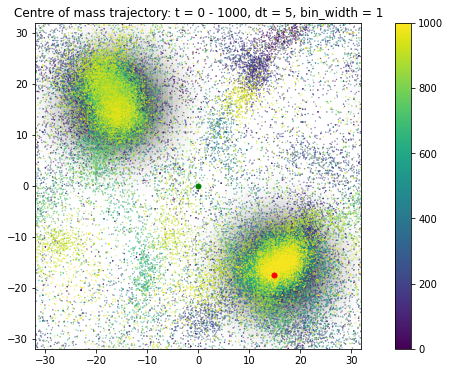

In [45]:
# Plotting
fig = plt.figure(figsize=(12,6))

plt.imshow(rate, extent=[-32,32,-32,32],cmap='gray_r')
# ax1.plot(masked_x,masked_y,'.-',markersize=2,linewidth=0.6)
plt.plot(COM_history['x'][0],COM_history['y'][0],'og',markersize=5,linewidth=0.1)
plt.plot(COM_history['x'][-1],COM_history['y'][-1],'or',markersize=5,linewidth=0.1)
plt.scatter(COM_history['x'],COM_history['y'],c = np.linspace(0,p.time,len(timesteps)-t_window), s = 0.1, \
    cmap = 'viridis')
plt.colorbar()
plt.xlim((-32,32))
plt.ylim((-32,32))
plt.title("Centre of mass trajectory: t = " + str(start_time) + " - " + str(1000) + 
    ", dt = " + str(t_window) + ", bin_width = " + str(binwidth))
plt.show()

WARNING    C:\Users\Evan Xie\AppData\Local\Temp\ipykernel_4656\3315282814.py:7: RuntimeWarning: invalid value encountered in true_divide
  unit_vec = np.array([COM_history['x']/r,COM_history['y']/r]).T
 [py.warnings]


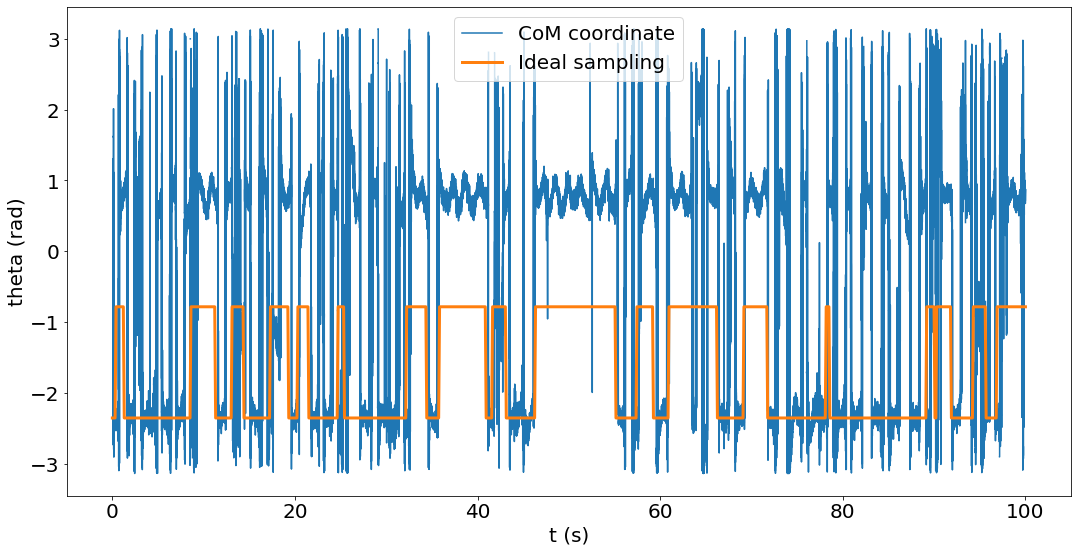

In [46]:
''' Plot out x or y coordinates of COM jumping, show Levy flight dynamics, reward tracking? '''

f, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(18,9))
fnts = 20

r = np.sqrt(COM_history['x']**2 + COM_history['y']**2)
unit_vec = np.array([COM_history['x']/r,COM_history['y']/r]).T
theta = np.arccos(np.clip(np.dot(unit_vec, [1,0]), -1.0, 1.0))
theta[COM_history['y']>0] = -theta[COM_history['y']>0]

optimal = np.argmax(payoffs,0)

ax1.plot(np.linspace(0,100,len(theta)),theta,label='CoM coordinate')
ax1.plot(np.linspace(0,100,p.time),optimal*np.pi/2-np.pi*3/4,label='Ideal sampling',linewidth=3)
ax1.set_ylabel('theta (rad)', fontsize=fnts)
# payoffs_ = payoffs/0.8 - 0.25
# ax1.plot(np.linspace(0,10,len(COM_history['x'])),COM_history['x'],label='CoM x coordinate')
# ax1.plot(linspace(0,10,len(payoffs[0,:])),payoffs_[1,:]*30-15,linewidth=3,label='Ideal sampling')  #*30-15,  28-21
ax1.legend(fontsize=fnts)
ax1.set_xlabel('t (s)', fontsize=fnts)
# ax1.set_ylabel('x-coordinate', fontsize=fnts)
ax1.tick_params(axis='both',labelsize=fnts)

filepath = 'C:/Users/Evan Xie/Desktop/EE_figures/thesis_figures/'
plt.savefig(filepath+'SNN_novelty_problem_choices')
plt.show()


In [7]:
''' Defining COM reward sampling for FNS'''

from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d

def sampleRewardPt(width,location):
    ''' Take 1 sample from 2D Gaussian. '''
    return np.random.multivariate_normal(location,[[width,0],[0,width]],1)

# def optionChoice_novel(x,payoffs,locations):
    
#     for i in range(len(locations)):



def rewardDynamic(x,payoffs,width,locations):
    ''' Given a position in the payoff landscape, return the reward. '''
    reward = 0
    for i in range(len(locations)):
        reward_feature = multivariate_normal(locations[i],[[width,0],[0,width]])
        reward += payoffs[i]*reward_feature.pdf(x)
    return reward

def rewardDynamicInd(x,payoffs,width,locations):
    ''' Given a position in the payoff landscape, sample independently from the closest feature. '''
    reward = 0
    distances = np.array([(x[0]-locations[i][0])**2 + (x[1]-locations[i][1])**2 for i in range(len(locations))])
    closest = np.argmin(distances)
    # print(distances)
    independent_sample = np.random.multivariate_normal(p.locations[closest],[[p.size,0],[0,p.size]])

    for i in range(len(locations)):
        reward_feature = multivariate_normal(locations[i],[[width,0],[0,width]])
        reward += payoffs[i]*reward_feature.pdf(independent_sample)
    return reward



def interpPayoffs(payoffs,steps):
    ''' Given a short payoff array, extend payoff in ratio to _steps_.'''
    f1 = interp1d(np.arange(len(payoffs[0])),payoffs[0],kind='previous')
    f2 = interp1d(np.arange(len(payoffs[1])),payoffs[1],kind='previous')
    xnew = np.linspace(0,len(payoffs[0])-1,steps)
    return xnew, [f1(xnew), f2(xnew)]

def collectReward(COM_history,payoffs,p):
    '''Collect reward occasionally from a long location history. '''
    # STEP 1: Figure out how often to collect reward.
    COM_array = np.array([COM_history['x'].T,COM_history['y'].T])

    n = len(COM_history['x'])
    m = len(payoffs[0,:])
    steps = np.arange(0,len(COM_history['x']),round(n/m))

    reward = np.zeros(steps.shape)
    for p_index,step in enumerate(steps):
        reward[p_index] = rewardDynamicInd(COM_array[:,step],payoffs[:,p_index],p.size,p.locations)
    
    return reward


In [8]:
''' Defining dUCB algorithm'''     
def sample(chosen,payoffs,sampled_points,p):
    ''' Take an array of chosen options, sample from corresponding array of 2D Gaussians and return payoff modulated reward '''
    x = sampled_points[chosen,np.random.randint(0,p.time)]      # select random location from chosen option 

    reward = 0
    for i in range(p.options):
        reward_feature = multivariate_normal(p.locations[i],[[p.size,0],[0,p.size]])
        reward += payoffs[i]*reward_feature.pdf(x)
    return reward


def dUCB1(p,payoff,n,dis):
    ''' Discounted UCB algorithm, taking uncertainty weight and discount factor. NO PRIOR IMPLEMENTED.''' 
    # Initialising recording structures and preallocating location samples
    sample_points = np.array([np.random.multivariate_normal(p.locations[idx],[[p.size,0],[0,p.size]],p.time) for idx in range(p.options)])

    scores = np.zeros(p.time)
    history = {idx: np.zeros(p.time) for idx in range(p.options)}   # Rewards obtained sorted by option
    history_choices = np.zeros(p.time)  # Which option was chosen at each time
    times_sampled = np.ones(p.options) # How many times has each option been sampled

    for opt in history:              # Sample from each option once
        scores[opt] = sample(opt,payoff[:,opt], sample_points,p)
        history[opt][opt] = scores[opt]
        history_choices[opt] = opt

    # Actual loop starting here.
    for t in range(p.options,p.time):
        EV = [np.sum(history[option])/times_sampled[option] for option in history]     # Mean history per option
        IB =  [n*np.sqrt(2*np.log(t) / times_sampled[option]) for option in history]
        UCB_rewards = np.transpose(np.add(EV,IB))
        chosen = np.argmax(UCB_rewards)
        
        scores[t] = sample(chosen,payoff[:,t],sample_points,p)
        history[chosen] = history[chosen] * dis     # Multiply in recent information bias for chosen option
        times_sampled[chosen] = times_sampled[chosen]*dis + 1
        history[chosen][t] = scores[t]
        history_choices[t] = chosen
    return scores,history_choices,history


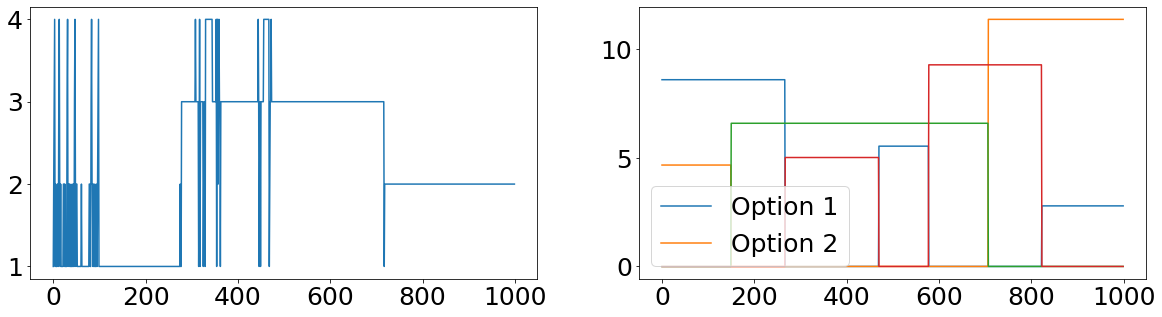

In [10]:
scores_dUCB,choices_dUCB,history_dUCB = dUCB1(p,payoffs,0.1,0.98)
# novelty problem: 0.1,0.98
# print(scores_dUCB[0:20])
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax1.plot(choices_dUCB+1)
ax2.plot(payoffs.T)
ax2.legend(['Option 1','Option 2'])

# plt.plot(payoffs[1])
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: 'Text' object has no property 'labelsize'

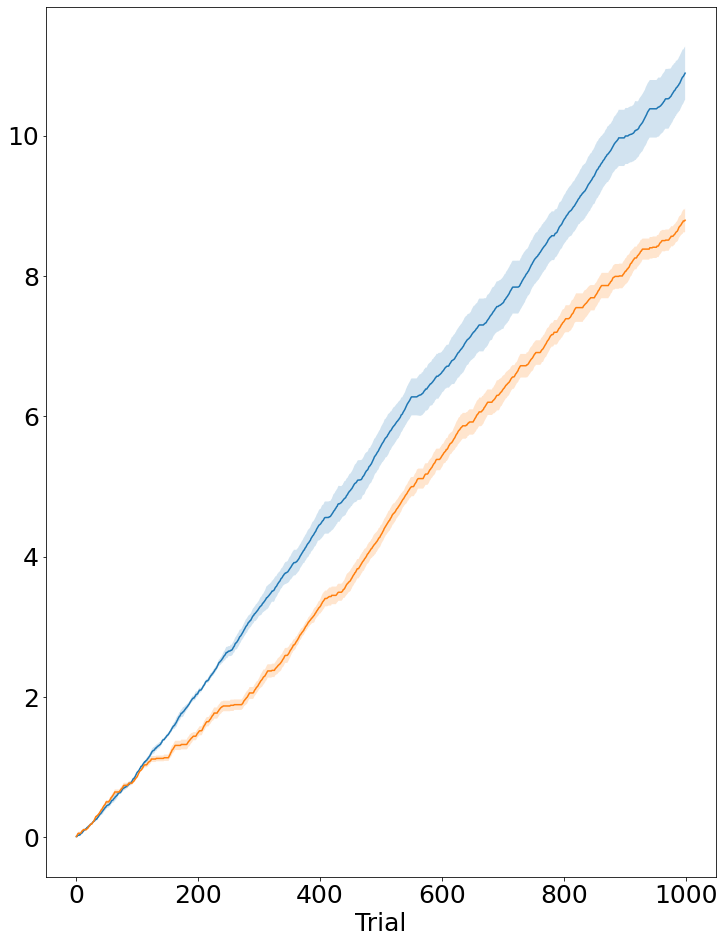

In [48]:
''' Plot cumulative reward'''
# xnew,payoffs_int= interpPayoffs(payoffs,len(COM_history['x']))
# COM_array = np.array([COM_history['x'].T,COM_history['y'].T])
# rewards = rewardDynamic(COM_array.T,payoffs_int,6,[[-16,16],[16,-16]])


avgs = 10
dUCB_avg = np.zeros((avgs,1000))
FNS_avg = np.zeros((avgs,1000))

for avg in tqdm_notebook(range(avgs)):
    scores_dUCB,choices_dUCB,history_dUCB = dUCB1(p,payoffs,0.1,0.98)
    rewards_nov = collectReward(COM_history,payoffs,p)
    dUCB_avg[avg,:] = scores_dUCB
    FNS_avg[avg,:] = rewards_nov


dUCB_cumu = np.cumsum(dUCB_avg,1)
FNS_cumu = np.cumsum(FNS_avg,1)
y1,std1 = np.mean(dUCB_cumu,0), np.std(dUCB_cumu,0)
y2,std2 = np.mean(FNS_cumu,0), np.std(FNS_cumu,0)


plt.figure(figsize=(12,16))
# plt.plot(np.arange(1000),np.cumsum(scores_dUCB),label='dUCB')
# plt.plot(np.arange(1000),np.cumsum(rewards_nov),label='FNS w/ 0.5 nS adaptation')
plt.plot(np.arange(1000),y1,label='dUCB')
plt.plot(np.arange(1000),y2,label='FNS w/ 0.5 nS adaptation')

plt.fill_between(range(1000), y1-std1, y1+std1, alpha=0.2)
plt.fill_between(range(1000), y2-std2, y2+std2, alpha=0.2)


plt.xlabel('Trial')
plt.ylabel('Cumulative Reward')
plt.rcParams.update({'font.size': 25})

plt.legend()
filepath = 'C:/Users/Evan Xie/Desktop/EE_figures/thesis_figures/'
# plt.savefig(filepath+'novelty_problem_performance_averaged')
plt.show()
